# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import log_loss, classification_report
#from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [126]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [127]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [128]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables que pueden ser útiles para el modelo

In [129]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


In [130]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   year         48532 non-null  int32         
 10  month        48532 non-null  int32         
 11  dayofweek    48532 non-null  int32         
 12  is_weekend   48532 non-null  int64         
 13  goal_diff    48532 non-null  int64         
 14  total_score  48532 non-null  int64         
 15  result       48532 non-null  object        
dtypes: b

In [131]:
results.describe()

,date,home_score,away_score,year,month,dayofweek,is_weekend,goal_diff,total_score
count,48532,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000
mean,1993-10-17 04:11:45.579823488,1.758180,1.181550,1993.265557,6.883664,3.457018,0.395945,1.716208,2.939730
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1980-02-27 00:00:00,1.000000,0.000000,1980.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,2000-03-15 00:00:00,1.000000,1.000000,2000.000000,7.000000,3.000000,0.000000,1.000000,3.000000
75%,2012-11-07 06:00:00,2.000000,2.000000,2012.000000,10.000000,5.000000,1.000000,2.000000,4.000000
max,2025-09-09 00:00:00,31.000000,21.000000,2025.000000,12.000000,6.000000,1.000000,31.000000,31.000000
std,NaN,1.773101,1.400946,25.301688,3.228533,1.981937,0.489058,1.791796,2.095142


Visualizaciones de variables numéricas

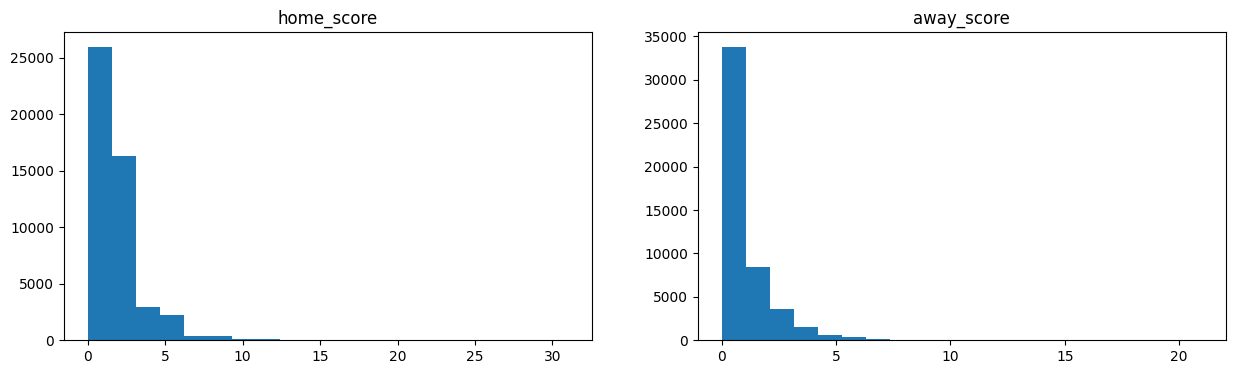

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

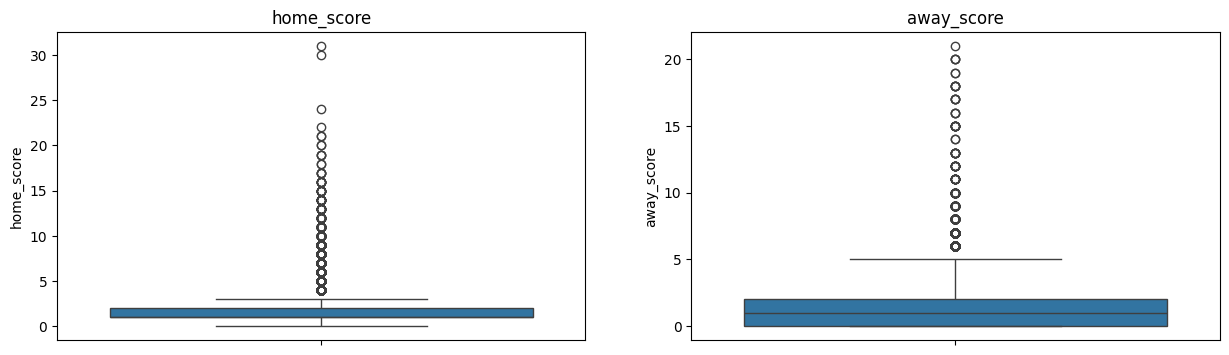

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

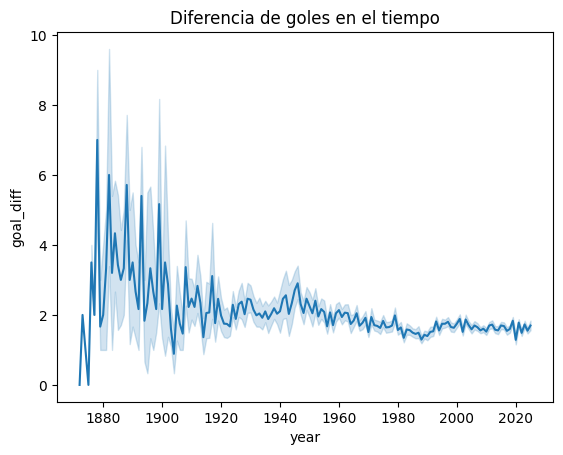

In [134]:
sns.lineplot(data=results, x="year", y="goal_diff")
plt.title("Diferencia de goles en el tiempo")
plt.show()

Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

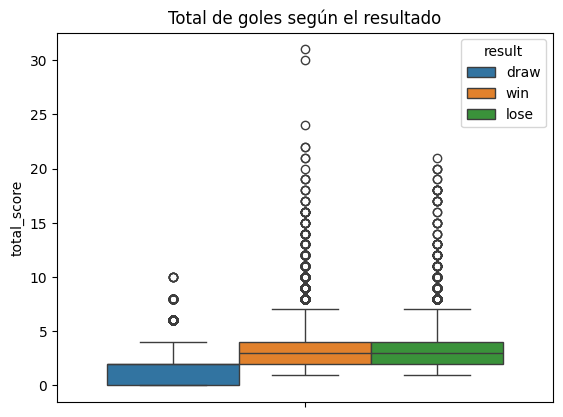

In [135]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

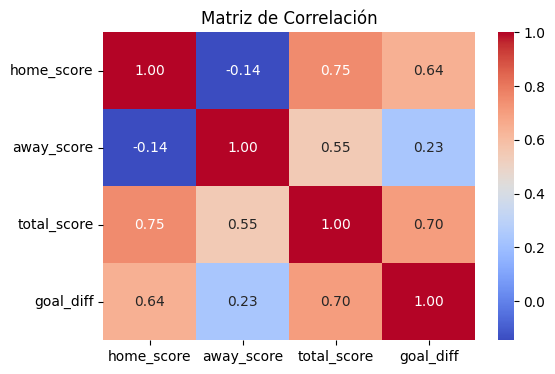

In [136]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Visualización de variables categoricas

In [137]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')

In [138]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48532,48532,48532,48532,48532,48532
unique,325,318,188,2115,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,578,18116,736,1458,23797


Veamos la distribución del target

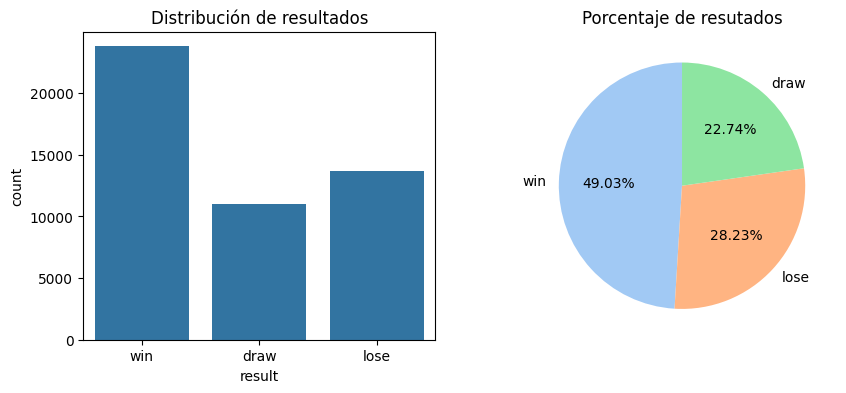

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

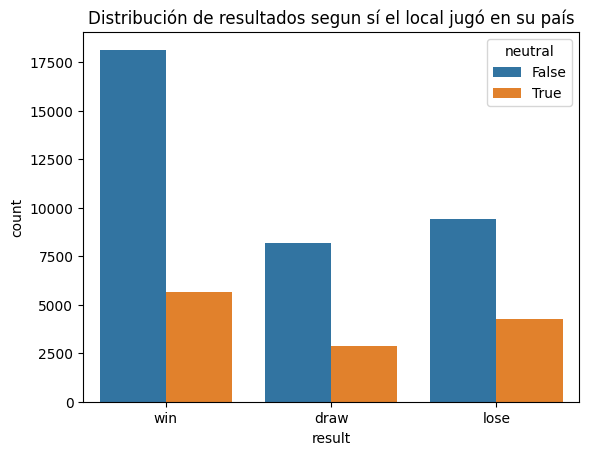

In [140]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

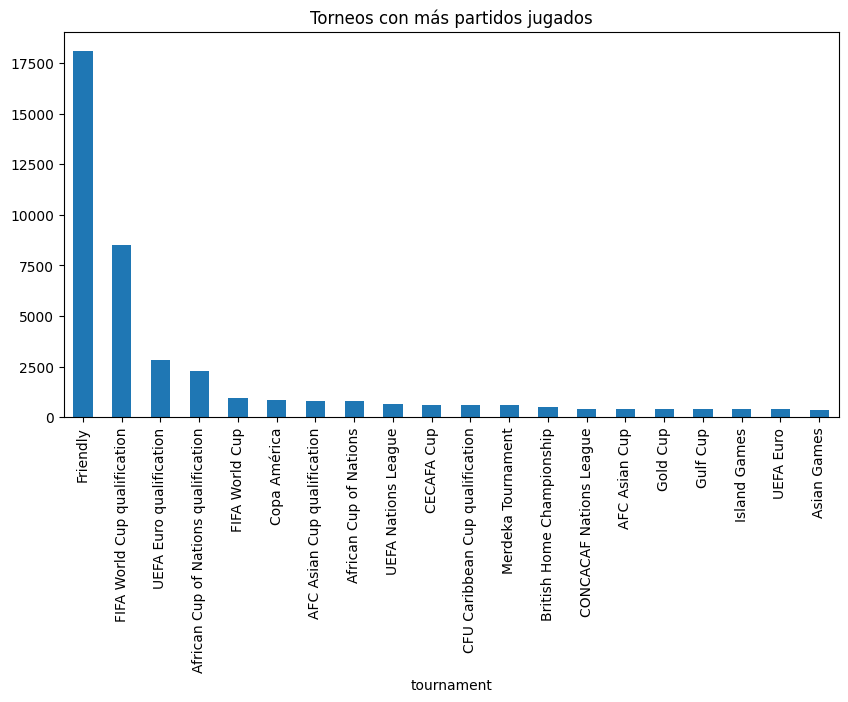

In [141]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

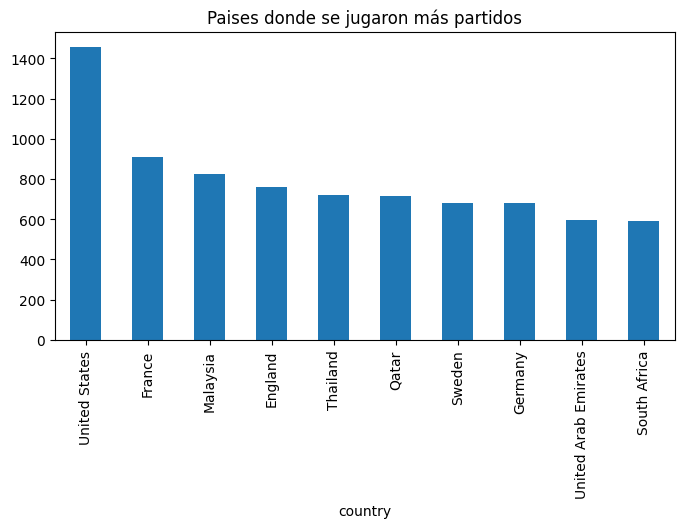

In [142]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

De los torneos, se destaca el tipo "amistoso" pero también aprecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

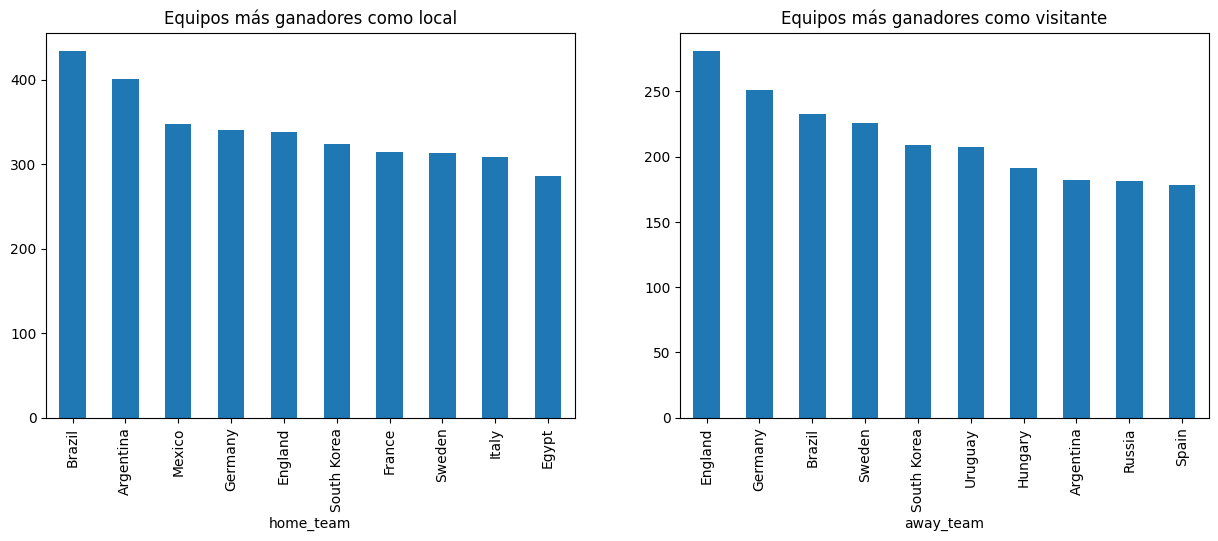

In [143]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

 Como no hay muchas variables representativas que permitan hacecr predicciones, vamos a basarnos en el ranking elo de los dos equipos y la diferencia entre ambos.

Para más detalles sobre el funcionamiento del sistema Elo y su aplicación en el ranking de equipos: [Sistema de puntuación Elo](https://es.wikipedia.org/wiki/Sistema_de_puntuaci%C3%B3n_Elo).

En este proyecto se asigna un valor inicial (1500) a cada equipo y se aplica un factor de ajuste (K = 30) para actualizar los ratings tras cada partido, considerando además una ventaja local de 100 puntos. De esta manera se actualizan las variables "home_elo", "away_elo" y "elo_diff", que resumen el rendimiento histórico de cada equipo.

In [144]:
from tqdm import tqdm

# --- Configuración del Elo ---
K = 30             # velocidad de ajuste
HOME_ADV = 100     # ventaja local
BASE_ELO = 1500    # rating inicial

# --- Copia ordenada por fecha ---
elo_df = results.sort_values("date").copy()

# --- Inicializar diccionario de ratings ---
elo_ratings = {}

home_elos = []
away_elos = []
rating_diffs = []

for _, row in tqdm(elo_df.iterrows(), total=len(elo_df)):
    home, away, result, neutral = row["home_team"], row["away_team"], row["result"], row["neutral"]

    # Si no existe el equipo, asignar rating base
    elo_ratings.setdefault(home, BASE_ELO)
    elo_ratings.setdefault(away, BASE_ELO)

    # Ratings actuales
    home_rating = elo_ratings[home]
    away_rating = elo_ratings[away]

    # Expectativa de victoria (ajustada por localía)
    exp_home = 1 / (1 + 10 ** (-(home_rating - away_rating + HOME_ADV) / 400))
    exp_away = 1 - exp_home

    # Resultado real codificado
    if result == "win":
        s_home, s_away = 1, 0
    elif result == "draw":
        s_home, s_away = 0.5, 0.5
    else:
        s_home, s_away = 0, 1

    # Actualizar ratings
    new_home = home_rating + K * (s_home - exp_home)
    new_away = away_rating + K * (s_away - exp_away)

    elo_ratings[home] = new_home
    elo_ratings[away] = new_away

    # Guardar features para el dataset
    home_elos.append(home_rating)
    away_elos.append(away_rating)
    rating_diffs.append(home_rating - away_rating)

# --- Agregar al DataFrame ---
elo_df["home_elo"] = home_elos
elo_df["away_elo"] = away_elos
elo_df["elo_diff"] = rating_diffs
elo_df["neutral"] = elo_df["neutral"].astype(int)

100%|██████████| 48532/48532 [00:00<00:00, 89687.73it/s]


Se filtran los partidos de modo que queden aquellos que se jugaron desde de 1920, ya que los anteriores pueden introducir ruido en el modelo. Vimos partidos con muchos goles antes de 1920, el fútbol era diferente entonces y había más diferencia entre los equipos.

In [145]:
results = results[results["date"].dt.year >= 1920].reset_index(drop=True)

#X_train, X_test = train_test_split(elo_df, test_size=0.2, random_state=42)

# También probamos con un split basado en fecha pero los resultados no fueron buenos
# test_df = results[results["date"] >= "2015-01-01"]
# results_filtered = results[results["date"] < "2015-01-01"]

#print("Train shape:", X_train.shape)
#print("Test shape:", X_test.shape)

In [146]:
# Null checks
print(elo_df.isna().sum()[elo_df.isna().sum() > 0])

Series([], dtype: int64)


Verificamos que no aparecen nulos.

Codificación: 

Las features son númericas y se escalan para que queden en la misma escala, con StandardScaler:
- "home_elo"
- "away_elo"
- "elo_diff"

El target:
- result se codifica con LabelEncoder por ser la variable a predecir

In [147]:
# --- Definir variables --- 
features_categoricas_target = [] #["tournament"] #["away_team", "tournament" ] #"country", "home_team",  "city", "year", "home_team", 
features_categoricas_one_hot = [] #["neutral"] #, "is_weekend"]

# Habíamos probado con estas features sin buenos resultados
# El mes es ciclico y lo debemos encodear como tal
#results_filtered["month_sin"] = np.sin(2 * np.pi * results_filtered["month"] / 12)
#results_filtered["month_cos"] = np.cos(2 * np.pi * results_filtered["month"] / 12)

features_numericas = ["home_elo", "away_elo", "elo_diff", "neutral"] 
                    # ["delta_winrate", "delta_loserate", #"delta_drawrate",
                    #  "delta_avg_gf", "delta_avg_ga"]
                    #  ["home_n_winrate", "home_n_loserate", "home_n_drawrate", 
                    #   "away_n_winrate", "away_n_loserate", "away_n_drawrate",
                    #   "home_n_avg_gf", "home_n_avg_ga",
                    #   "away_n_avg_gf", "away_n_avg_ga"
                    #   ] #"month_sin", "month_cos", "home_score", "away_score", 

In [148]:

le = LabelEncoder()
elo_df["result_enc"] = le.fit_transform(elo_df["result"])
print("Clases del resultado: ", le.classes_)

# neutral no se usó al final
#results_filtered["neutral"] = results_filtered["neutral"].astype(str)
#test_df["neutral"] = test_df["neutral"].astype(str)

# Separar X / y ---
X = elo_df[features_numericas + features_categoricas_one_hot + features_categoricas_target].copy()
y = elo_df["result_enc"]

train_df, test_df = train_test_split(elo_df, test_size=0.2, shuffle=False)

X_train = train_df[features_numericas + features_categoricas_one_hot + features_categoricas_target]
X_test = test_df[features_numericas + features_categoricas_one_hot + features_categoricas_target]
y_train = train_df["result_enc"]
y_test = test_df["result_enc"]

# Preprocesamiento: escalado + one-hot y target encoding 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_numericas),
        #("cat_o", OneHotEncoder(handle_unknown="ignore"), features_categoricas_one_hot),
        #("cat_t", TargetEncoder(handle_unknown="ignore"), features_categoricas_target)
    ]
)

# Pipeline general ---
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# --- Aplicar transformaciones ---
X_processed = pipeline.fit_transform(X, y)

print("Shape original:", X.shape)
print("Shape transformada:", X_processed.shape)


Clases del resultado:  ['draw' 'lose' 'win']
Shape original: (48532, 4)
Shape transformada: (48532, 4)


In [149]:
# Esto lo usamos para visualizar un equipo en particular

#X[((X['home_team'].isin(['Colombia'])))] #| (X['away_team'].isin(['Colombia']))) & (X['year'] == 2025)]

#y[((y['home_team'].isin(['Colombia'])) | (y['away_team'].isin(['Colombia']))) & (y['year'] == 2025)]

In [150]:
from sklearn.feature_selection import SelectFpr, f_classif 
selector_anova = SelectFpr(score_func=f_classif, alpha=0.05)

selector_anova.fit(X_processed, y)

print("Número de variables seleccionadas:", selector_anova.get_support().sum())

Número de variables seleccionadas: 4


In [151]:
# Esto significa que las 4 columnas finales tienen una relación estadísticamente significativa (p < 0.05) con tu variable objetivo y.

# Ahora miremos los pesos
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
scores = pd.DataFrame({
    "feature": feature_names,
    "f_score": selector_anova.scores_,
    "p_value": selector_anova.pvalues_
}).sort_values("f_score", ascending=False)

print(scores)

         feature      f_score       p_value
2  num__elo_diff  6578.581560  0.000000e+00
1  num__away_elo  1921.415014  0.000000e+00
0  num__home_elo  1528.107633  0.000000e+00
3   num__neutral   122.334004  1.010412e-53


Quedan en total 4 variables significativas. En pruebas anteriores encontramos que otras son linealmente dependientes y se excluyeron y otras no representan relación estadistica con la variable objetivo.

<Axes: >

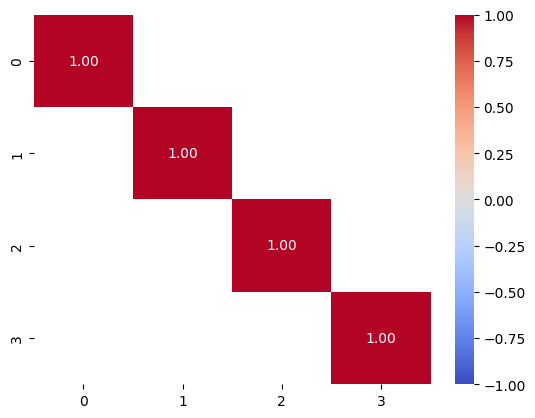

In [152]:
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)
corr = np.abs(pd.DataFrame(X_df).corr())

mask_for_heatmap = corr < 0.70

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)

Hemos reducido la dimensionalidad hasta llegar a las 4 variables más significativas

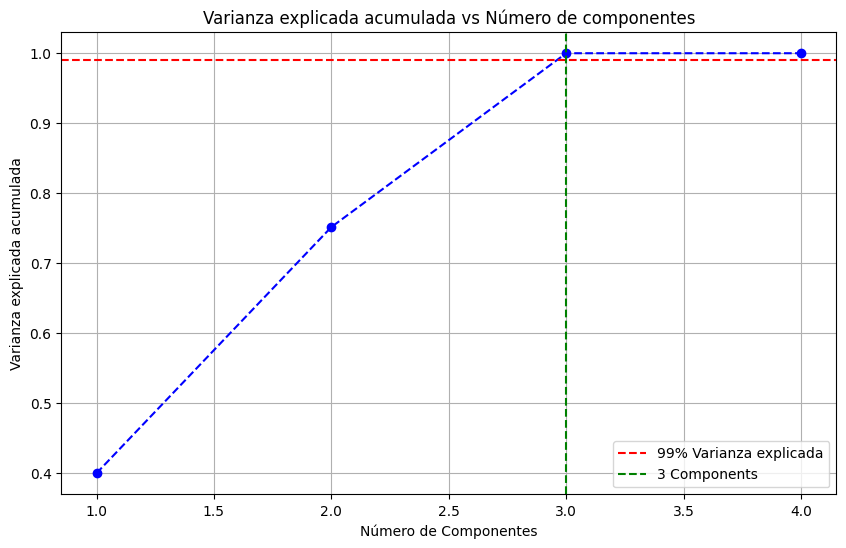

In [153]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_processed)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs Número de componentes')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Varianza explicada')  
plt.axvline(x=np.argmax(cumulative_variance >= 0.99) + 1, color='g', linestyle='--', label=f'{np.argmax(cumulative_variance >= 0.99) + 1} Components')
plt.legend(loc='best')
plt.grid()
plt.show()

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

Inicialmente formulamos el problema de la siguiente manera.

"Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una serie temporal. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada."

Luego al observar los resultados no muy favorables, hicimos el train test split. 

In [154]:
def print_classification_results(y_test, y_pred, model_name, y_proba=None):
    target_names = le.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
    
    if y_proba is not None:
        print("Log Loss:", log_loss(y_test, y_proba))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

In [155]:

#from sklearn.impute import SimpleImputer

# Modelo baseline: regresión logística multiclase
# Train / test split already done
# X_train = results_filtered[features_numericas + features_categoricas_one_hot + features_categoricas_target]
# y_train = results_filtered["result_enc"]

# X_test = test_df[features_numericas + features_categoricas_one_hot + features_categoricas_target]
# y_test = test_df["result_enc"]

# Column transformers
num_transformer = Pipeline([
    #("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# actualmente la lista de features categoricas de poca cardinalidad está vacía, la dejamos por si esto cambia en el futuro
cat_o_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# actualmente la lista de features categoricas para target encoding está vacía, la dejamos por si esto cambia en el futuro
cat_t_transformer = Pipeline([
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target", TargetEncoder(handle_unknown="value", handle_missing="value"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, features_numericas),
    ("cat_o", cat_o_transformer, features_categoricas_one_hot),
    ("cat_t", cat_t_transformer, features_categoricas_target)
])


Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación


Resultados para Regresión Logística:

Accuracy: 0.5731946018337283
F1-score (macro): 0.5161504677355117
Log Loss: 0.9077824365035904

Classification Report:
               precision    recall  f1-score   support

        draw       0.30      0.24      0.26      2235
        lose       0.55      0.64      0.59      2826
         win       0.69      0.70      0.69      4646

    accuracy                           0.57      9707
   macro avg       0.51      0.52      0.52      9707
weighted avg       0.56      0.57      0.56      9707



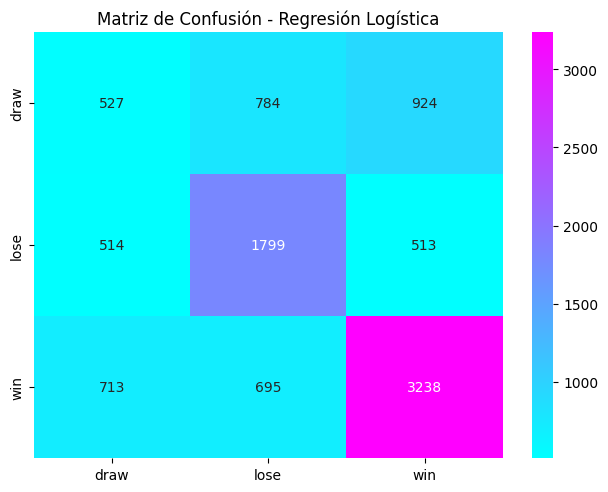

In [156]:
# Regresión logística con balanceo de clases
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', logreg)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Regresión Logística", y_proba)


Resultados para kNN:

Accuracy: 0.5254970639744514
F1-score (macro): 0.493101725915514
Log Loss: 1.1245294458261217

Classification Report:
               precision    recall  f1-score   support

        draw       0.27      0.31      0.29      2235
        lose       0.53      0.58      0.55      2826
         win       0.69      0.60      0.64      4646

    accuracy                           0.53      9707
   macro avg       0.50      0.49      0.49      9707
weighted avg       0.55      0.53      0.53      9707



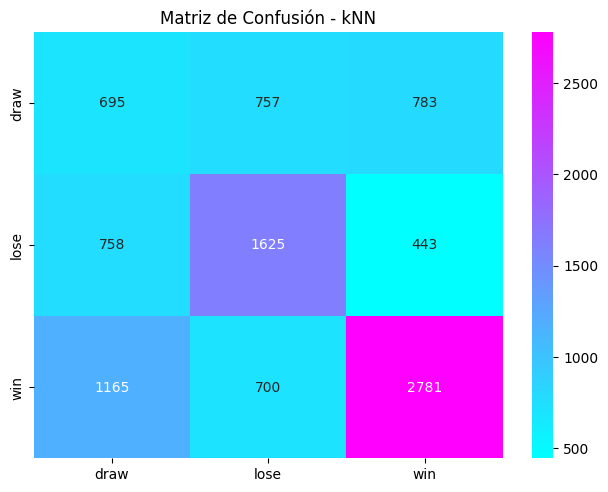

In [157]:
from imblearn.pipeline import Pipeline as ImbPipeline

# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)

# balance de clases con undersampling
sampler = RandomUnderSampler(random_state=42)

pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),       
    ('sampler', sampler), # balancea
    ('model', knn)
])

# Train
pipeline_rus.fit(X_train, y_train)

# Predict
y_pred = pipeline_rus.predict(X_test)
y_proba = pipeline_rus.predict_proba(X_test)

print_classification_results(y_test, y_pred, "kNN", y_proba)


Resultados para SVC:

Accuracy: 0.5660863294529721
F1-score (macro): 0.5182349366631068
Log Loss: 0.9121442582549643

Classification Report:
               precision    recall  f1-score   support

        draw       0.30      0.27      0.28      2235
        lose       0.55      0.63      0.59      2826
         win       0.70      0.67      0.69      4646

    accuracy                           0.57      9707
   macro avg       0.52      0.52      0.52      9707
weighted avg       0.56      0.57      0.56      9707



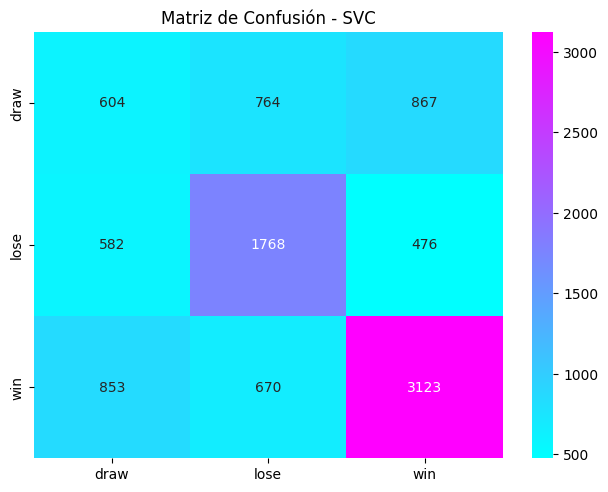

In [158]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovo', probability=True, class_weight='balanced', random_state=42)

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "SVC", y_proba)


Resultados para Árbol de Decisión:

Accuracy: 0.5418769959822808
F1-score (macro): 0.5048812075044811
Log Loss: 1.88455798157181

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.31      0.30      2235
        lose       0.56      0.56      0.56      2826
         win       0.68      0.64      0.66      4646

    accuracy                           0.54      9707
   macro avg       0.51      0.50      0.50      9707
weighted avg       0.55      0.54      0.55      9707



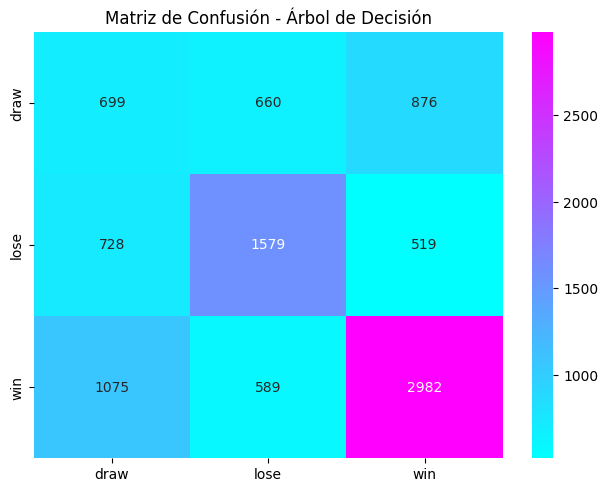

In [159]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', dtc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Árbol de Decisión", y_proba)


Resultados para Random Forest:

Accuracy: 0.5575357989080045
F1-score (macro): 0.4972273886521765
Log Loss: 0.9526767441160588

Classification Report:
               precision    recall  f1-score   support

        draw       0.27      0.21      0.24      2235
        lose       0.54      0.61      0.57      2826
         win       0.67      0.70      0.68      4646

    accuracy                           0.56      9707
   macro avg       0.49      0.50      0.50      9707
weighted avg       0.54      0.56      0.55      9707



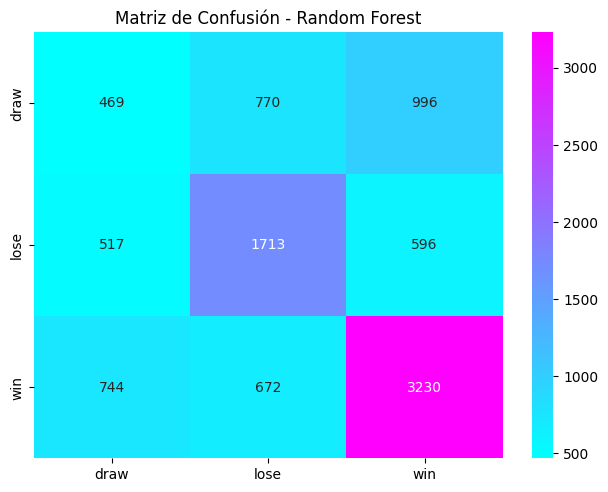

In [160]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)

pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rfc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Random Forest", y_proba)


Resultados para GradientBoostingClassifier:

Accuracy: 0.5230246214072319
F1-score (macro): 0.4861175876279144
Log Loss: 0.968329792923857

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.28      0.27      2235
        lose       0.52      0.58      0.55      2826
         win       0.68      0.61      0.64      4646

    accuracy                           0.52      9707
   macro avg       0.49      0.49      0.49      9707
weighted avg       0.54      0.52      0.53      9707



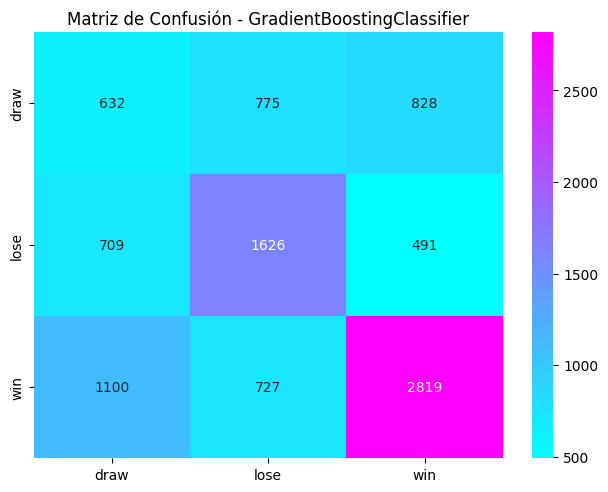

In [161]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    n_estimators=300,     # más árboles = mejor performance, hasta cierto punto
    learning_rate=0.05,   # tasa de aprendizaje baja = más estable
    max_depth=10,          # profundidad de cada árbol
    random_state=42
)

# balance de clases con undersampling
sampler = RandomUnderSampler(random_state=42)

pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),       
    ('sampler', sampler), # balancea
    ('model', gb_clf)
])

# Train
pipeline_rus.fit(X_train, y_train)

# Predict
y_pred = pipeline_rus.predict(X_test)
y_proba = pipeline_rus.predict_proba(X_test)

print_classification_results(y_test, y_pred, "GradientBoostingClassifier", y_proba)


Resultados para XGBClassifier:

Accuracy: 0.5595961677140208
F1-score (macro): 0.5114983371760896
Log Loss: 0.9208597697068096

Classification Report:
               precision    recall  f1-score   support

        draw       0.29      0.27      0.28      2235
        lose       0.54      0.62      0.57      2826
         win       0.70      0.67      0.68      4646

    accuracy                           0.56      9707
   macro avg       0.51      0.52      0.51      9707
weighted avg       0.56      0.56      0.56      9707



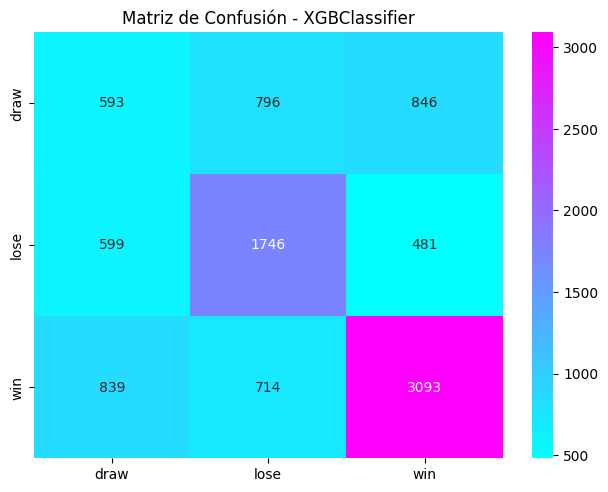

In [162]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    random_state=42
)

# balance de clases con undersampling
sampler = RandomUnderSampler(random_state=42)

pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),       
    ('sampler', sampler), # balancea
    ('model', xgb)
])

# Train
pipeline_rus.fit(X_train, y_train)

# Predict
y_pred = pipeline_rus.predict(X_test)
y_proba = pipeline_rus.predict_proba(X_test)

print_classification_results(y_test, y_pred, "XGBClassifier", y_proba)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 38825, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

Resultados para LGBMClassifier:

Accuracy: 0.555063356340785
F1-score (macro): 0.5054216595183082
Log Loss: 0.9227466445766683

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.26      0.27      2235
        lose       0.54      0.60      0.57      2826
         win       0.69      0.67      0.68      4646

    accuracy                           0.56      9707
   macro avg       0.50      0.51      0.51      9707
weighted

/Users/carlosrivas/Study/AdM/tpAdM/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/carlosrivas/Study/AdM/tpAdM/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


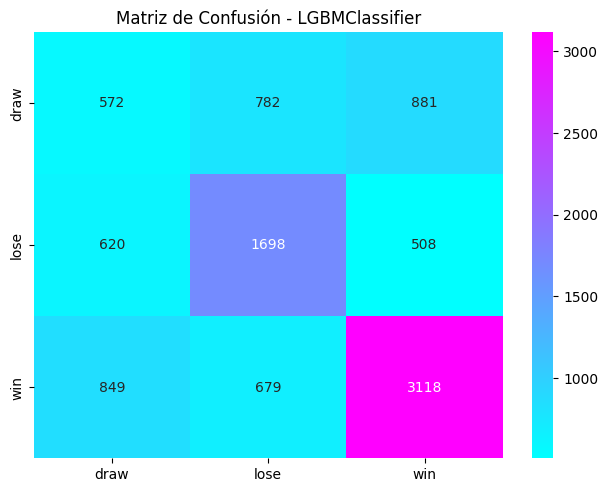

In [163]:
import lightgbm as lgb

# --- Definir el modelo LightGBM ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,  # sin límite de profundidad
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multiclass',
    class_weight='balanced',
    random_state=42
)

pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb_model)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "LGBMClassifier", y_proba)

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global.

In [164]:
# Comparacion de resultados

---
Para discutir:

- ¿Qué otras variables podrían ser útiles para mejorar el modelo? Una ordinal por ejemplo el peso del torneo o la confederación?

- Faltaria agregar ensamble 

- Y si convertimos el problema a uno de clasificación binaria (win vs no win)? Podria simplificar el problema y mejorar los resultados?

Algunas consideraciones:

- El modelo logístico (lineal) está rindiendo mejor que los no lineales:
 - Los features son informativos pero no muy complejos
 - Los árboles no funcionan muy bien (quizás mucho ruido o pocos ejemplos representativos por matchup)

- El F1 macro ≈ 0.51–0.52 puede indicar que los modelos captan bien “win vs lose”, pero no los “draw”
- Los empates son raros e inducen ruido, y las features no los predicen bien

Siguientes pasos:

- (win vs no win) puede funcionar mejor en esta linea

- hablar con cesar para ir en esa linea en ambos notebooks 

- revisar de cara a la consigna

- completar punto 4